<a href="https://github.com/labrijisaad/Energy-Forecast-API/blob/main/notebooks/EDA & Data Preparation - Energy_Forecasting.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/Open%20in-GitHub-blue.svg" alt="Open In GitHub"/>
</a>

## <center><a><span style="color:blue">`EDA & Data Preparation` - Energy Forecasting Dataset</span></a></center>

### Import the needed libraries

In [1]:
# Supress warnings
import warnings ; warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd ; pd.set_option('display.max_columns', None) ; pd.set_option('display.max_rows', 4)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns ; color_pal = sns.color_palette("husl", 9) ; plt.style.use('fivethirtyeight')

# Utilities
from datetime import datetime, date
import math
import os
import re

# Data missingness visualization
import missingno as msno

### Importing Data

First, we will download the Household Electric Power Consumption data available at the [link](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption). Additionally, we will perform some light transformations to convert it into a time series with a daily frequency.

In [2]:
# Read the CSV data
consumptions = pd.read_csv('../data/raw/energy/household_power_consumption.zip', sep =';', header=0, na_values='?', 
                           dtype={'Date':str, 'Time':str, 'Global_active_power':np.float64}, 
                           infer_datetime_format=False)

# Standardise column names using lower case
consumptions.rename(
    columns = {
        'Date':'date',
        'Time':'time',
        'Global_active_power':'total_consumption'
        },
    inplace=True
)

# Define the dataframe index based on the timestamp (date-time)
consumptions.index = pd.to_datetime(
    consumptions.date + "-" + consumptions.time,
    format = "%d/%m/%Y-%H:%M:%S"
)

# Drop the date and time variables that are now redondant with the index
consumptions.drop(columns=['date', 'time'], inplace=True)

# We resample for you to continue the exercise
consumptions_df = consumptions.resample('D').sum()
consumptions_df.tail(3)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0
2010-11-25,1431.164,116.128,347812.21,6004.0,1076.0,426.0,5072.0
2010-11-26,1488.104,120.826,303487.57,6259.8,1080.0,385.0,9989.0


### <a><span style="color:red">`EDA` - Exploratory Data Analysis</span></a>
In this part, we will conduct Exploratory Data Analysis (EDA) to gather as much information about the data as possible. This will help us in selecting an appropriate ML model.

In [3]:
# Dataframe head 
consumptions_df.head(2)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0


In [4]:
# Dataframe tail 
consumptions_df.tail(2)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-11-25,1431.164,116.128,347812.21,6004.0,1076.0,426.0,5072.0
2010-11-26,1488.104,120.826,303487.57,6259.8,1080.0,385.0,9989.0


In [5]:
# Print the Column names
consumptions_df.columns

Index(['total_consumption', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

Only one column is present, and it's the target.

In [6]:
print(consumptions_df.shape)
consumptions_df.info()

(1442, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_consumption      1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
dtypes: float64(7)
memory usage: 90.1 KB


We have a total of **1442** records over the time in the df

#### Visualizing Electric Power Consumption Over Time

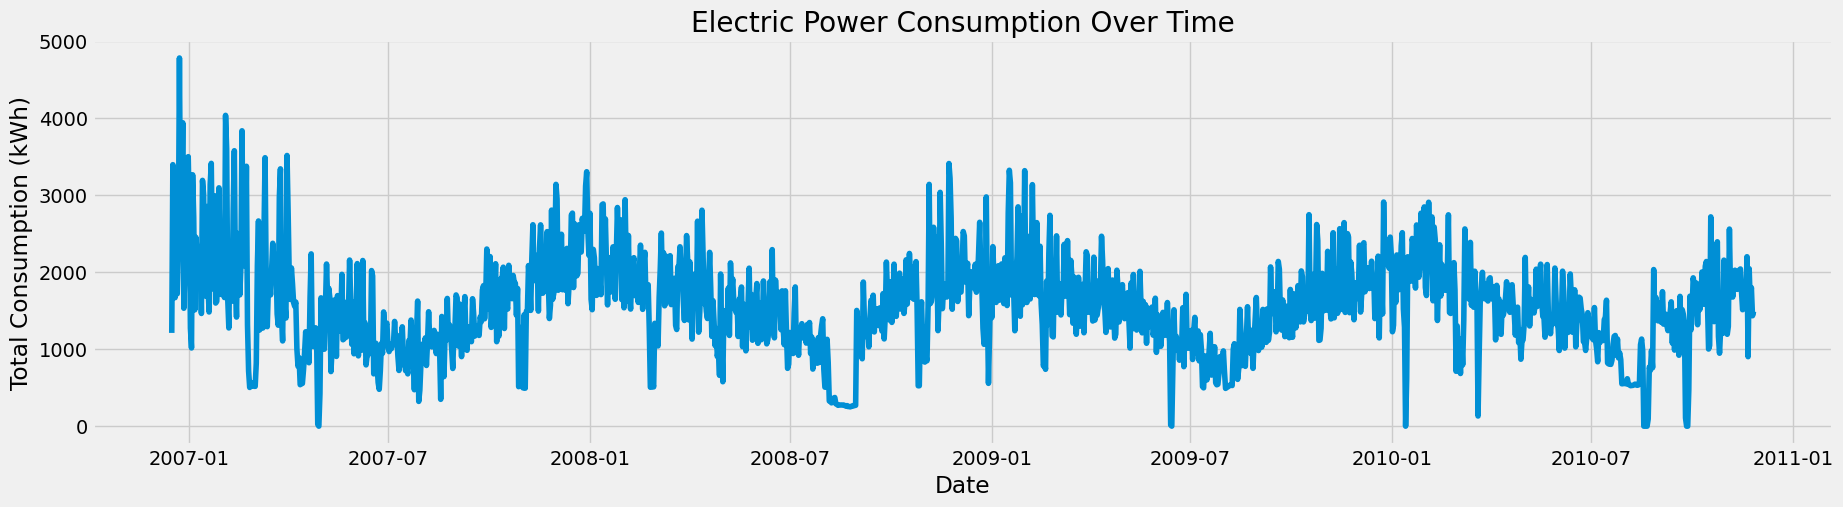

In [7]:
plt.figure(figsize=(20,5))
plt.title('Electric Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Consumption (kWh)')
plt.plot(consumptions_df['total_consumption'])
plt.show()

#### Observations and Insights About the Graph:

- **Seasonality**: The graph displays a recurring one-year pattern, indicating seasonal trends. **Utilizing time features could be usefull**.
- **Trend**: The overall trend seems stable, with no clear long-term increase or decrease. **This suggests a relatively constant mean over the years**.
- **Variance**: The **consistency in the amplitude of seasonal peaks** and troughs suggests suitability for models like ARIMA.
- **Outliers**: Several spikes are notable. Addressing these outliers may be necessary.

#### Checking missing values

<Axes: >

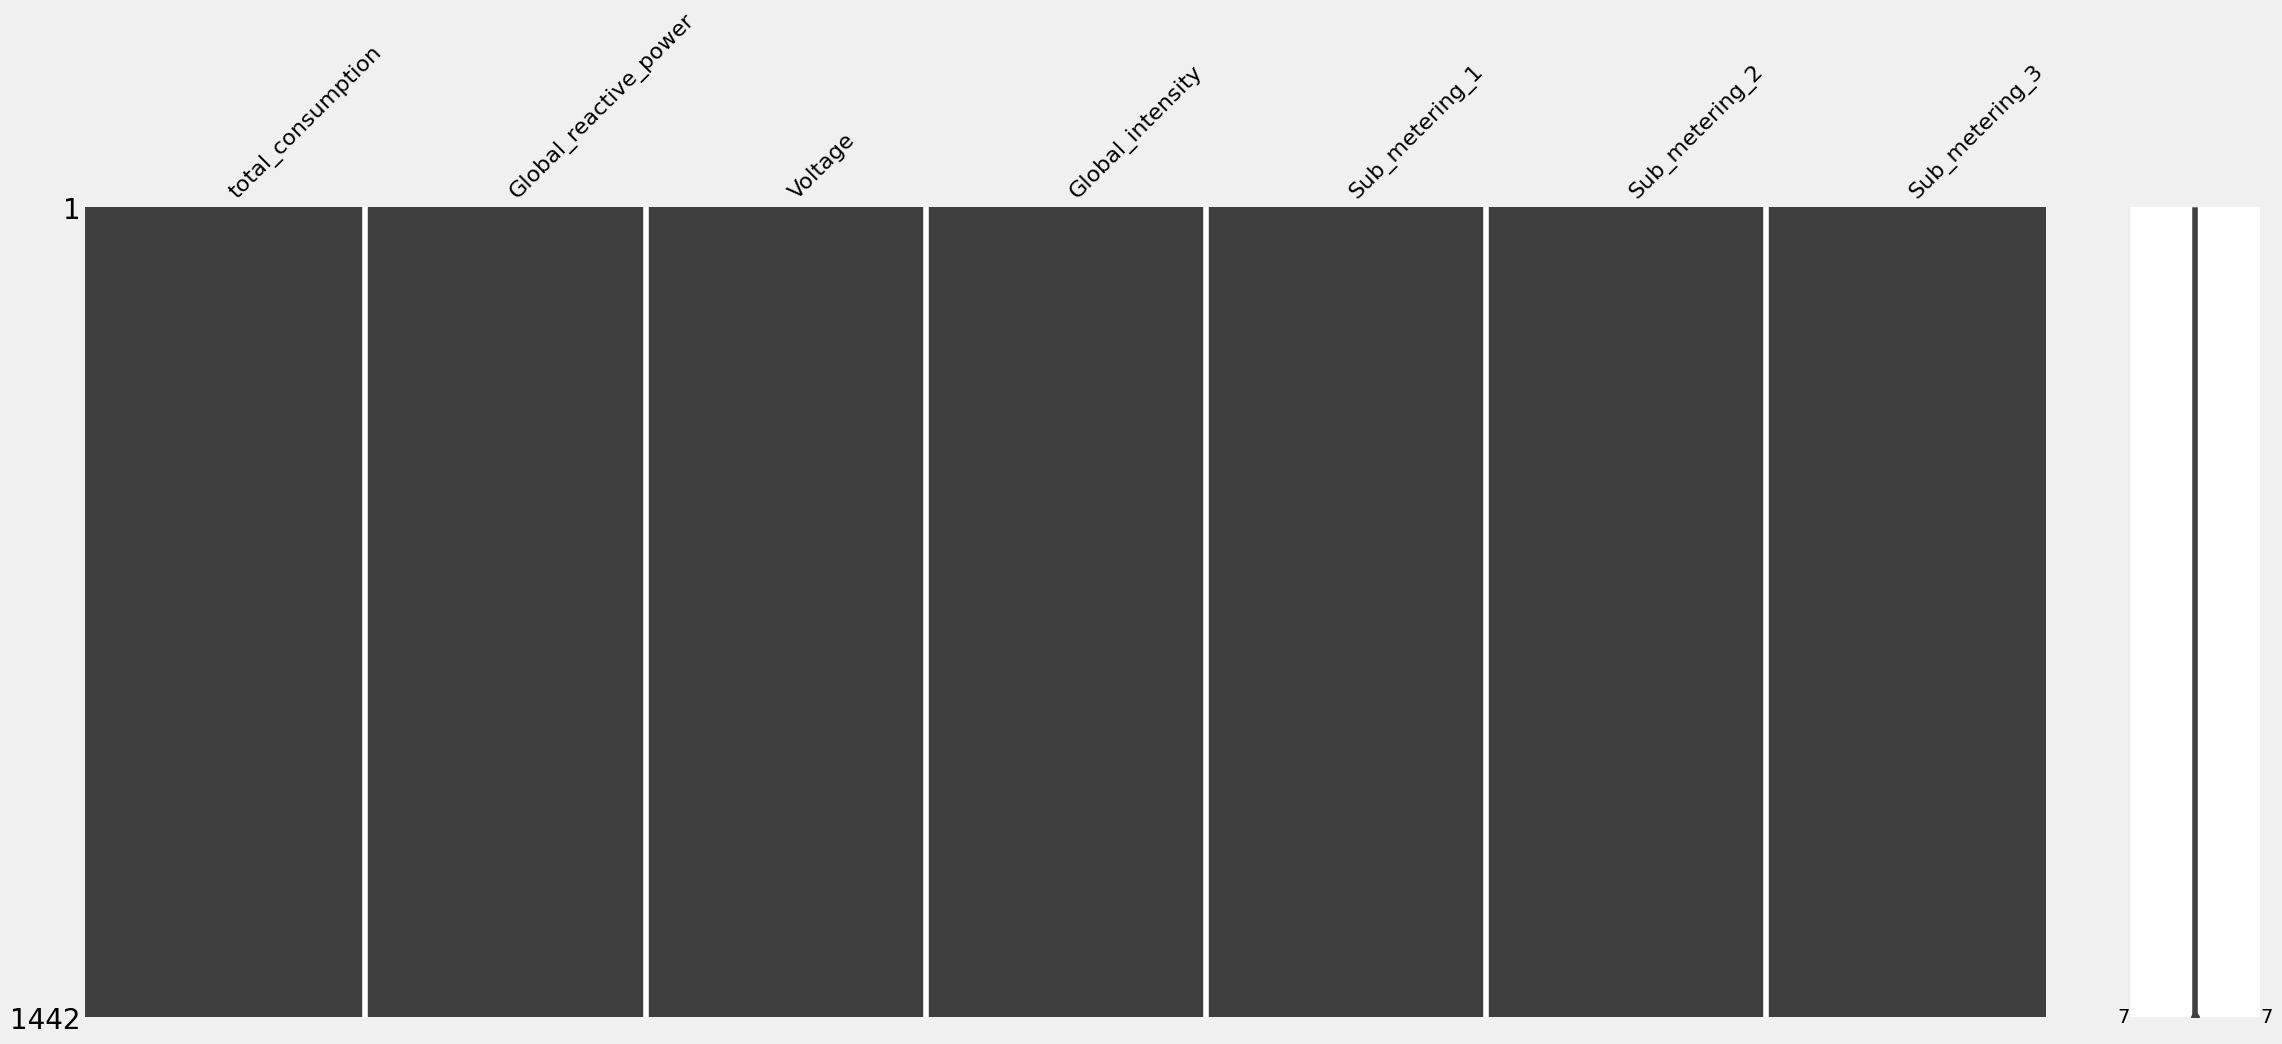

In [8]:
msno.matrix(consumptions_df)

There is no missing values on the dataset.

#### Visualizing Electric Power Consumption Trends Over Time

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
The metric <b><code>ρ (rho)</code></b> quantifies the association between a qualitative variable (e.g., day of the week, month) and a quantitative variable (e.g., total electricity consumption). This metric is often referred to as <b>ANOVA's F-statistic</b> when used in the context of comparing variances among groups. It's calculated as the ratio of the within-groups sum of squares to the total sum of squares, reflecting how much the group means deviate from the overall mean. The formula for ANOVA's F-statistic is:

$$
\rho = \frac{\sum_{\ell=1}^{L} n_{\ell} (\bar{T}_{j(\ell)} - \bar{T})^2}{\sum_{i=1}^{n} (T_i - \bar{T})^2}
$$

<b>Interpretation:</b> A <span style="color:green"><b>ρ close to 0</b></span> indicates a <span style="color:green"><b>negligible effect</b></span> of the qualitative variable on the quantitative measure, whereas a <span style="color:green"><b>ρ close to 1</b></span> suggests a <span style="color:green"><b>substantial impact</b></span>. Understanding ρ helps in discerning the significance of different categorical levels in explaining the variance of the quantitative data.
</div>

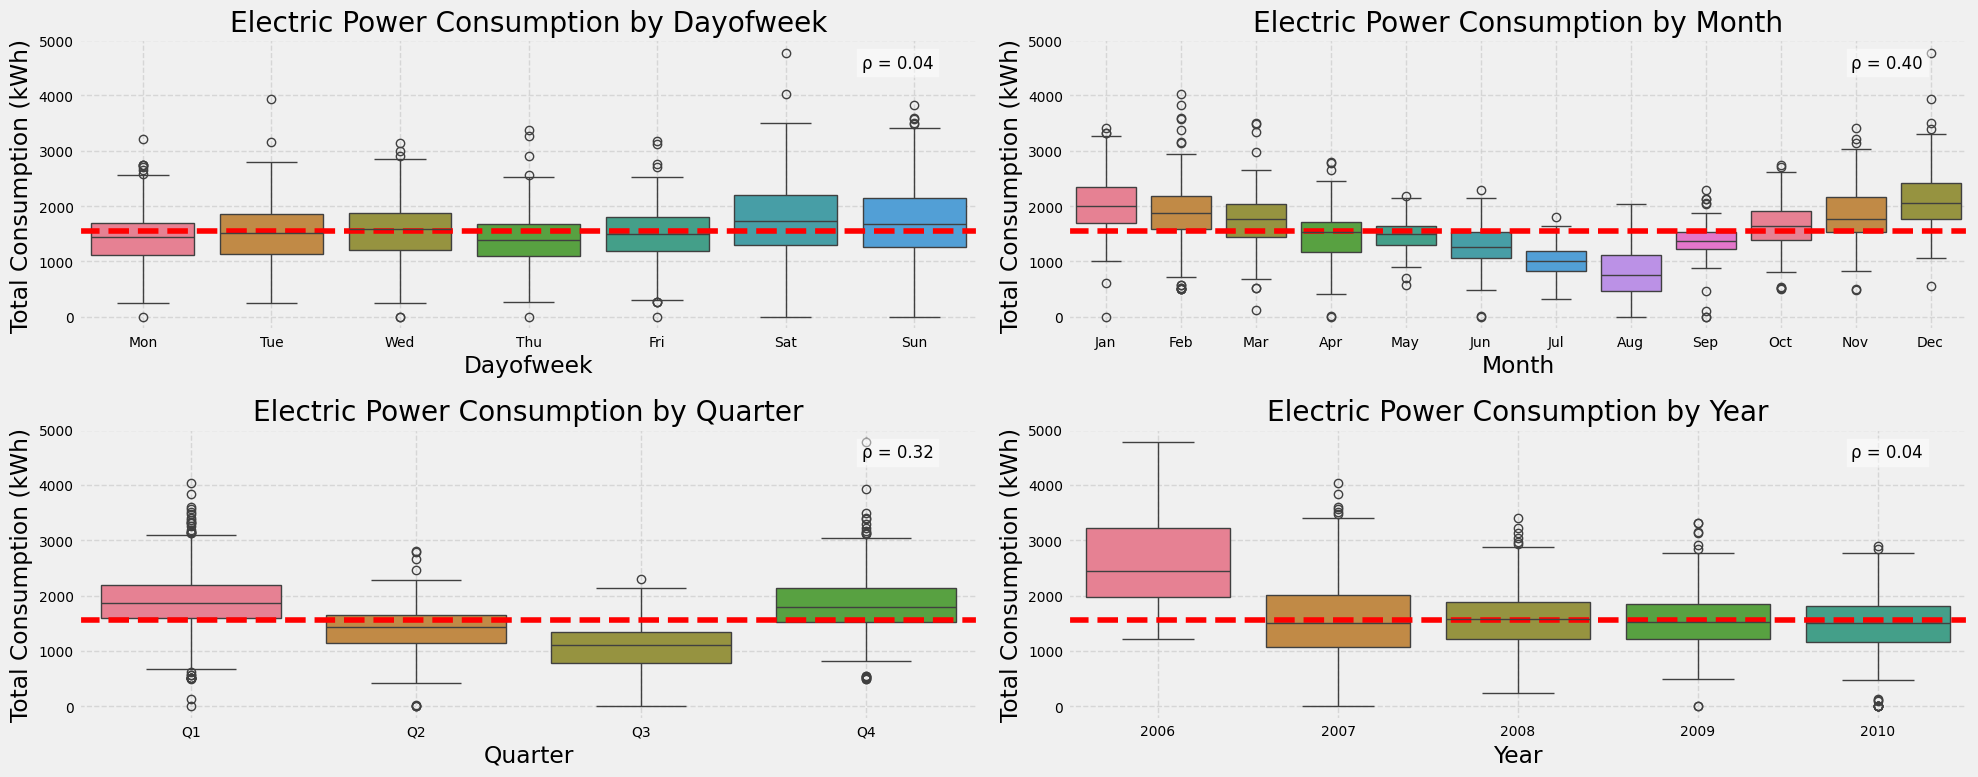

In [9]:
# Function to calculate the rho association metric
def calculate_rho(grouped_data, overall_mean):
    sum_of_squares_within = sum(grouped_data.apply(lambda x: len(x) * (x.mean() - overall_mean)**2))
    total_sum_of_squares = sum((consumptions_df_copy['total_consumption'] - overall_mean)**2)
    rho = sum_of_squares_within / total_sum_of_squares
    return rho

# Copy the data for transformations
consumptions_df_copy = consumptions_df.copy()

# Assuming consumptions_df_copy index is a datetime index if not convert it before running this
# Create time series features based on time series index
consumptions_df_copy['dayofweek'] = consumptions_df_copy.index.dayofweek
consumptions_df_copy['month'] = consumptions_df_copy.index.month
consumptions_df_copy['quarter'] = consumptions_df_copy.index.quarter
consumptions_df_copy['year'] = consumptions_df_copy.index.year

# Overall mean of total consumption
overall_mean = consumptions_df_copy['total_consumption'].mean()

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 8))

# List of categories
categories = ['dayofweek', 'month', 'quarter', 'year']
category_labels = [
    ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ['Q1', 'Q2', 'Q3', 'Q4'],
    range(consumptions_df_copy['year'].min(), consumptions_df_copy['year'].max() + 1)
]

# Plot for each category
for i, (category, labels) in enumerate(zip(categories, category_labels)):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=consumptions_df_copy, x=category, y='total_consumption', ax=ax, palette=color_pal)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Calculate the rho value for the category
    grouped = consumptions_df_copy.groupby(category)['total_consumption']
    rho = calculate_rho(grouped, overall_mean)
    
    # Add the rho value as text on the plot
    ax.text(0.95, 0.95, f'ρ = {rho:.2f}',
            transform=ax.transAxes, 
            horizontalalignment='right',
            verticalalignment='top',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.5))
    
    # Add a red line for the overall mean
    ax.axhline(overall_mean, color='red', linestyle='--')
    
    ax.set_title(f'Electric Power Consumption by {category.capitalize()}')
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel('Total Consumption (kWh)')
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

#### Observations and Insights About the Graph:

- **Seasonal Trends**: Significant during summer (June-August) with higher consumption, as indicated by a moderate ρ of 0.40 in those months. This suggests a potential feature for modeling peak usage periods.
- **Weekly Patterns**: Minimal variation with a ρ of 0.04, indicating day of the week may have less predictive power.
- **Yearly Consistency**: Stable annual consumption (ρ of 0.04) suggests year feature may not be a strong predictor in the model.
- **Quarterly Influence**: A noticeable increase in Q3 aligns with seasonal trends and should be considered in the model.
- **Outliers**: Presence of outliers might necessitate robust or regularized models to prevent overfitting on these anomalies.

#### Analyzing the Linear Correlation between the Target and the Features

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
The correlation coefficient, denoted as <b><code>r</code></b>, measures the strength and direction of a linear relationship between two quantitative variables. Its values range from <b>-1</b> to <b>1</b>, where:

<ul>
<li><b><code>r = 1</code></b>: There's a perfect positive linear relationship between the variables.</li>
<li><b><code>r = -1</code></b>: There's a perfect negative linear relationship between the variables.</li>
<li><b><code>r = 0</code></b>: No linear relationship exists between the variables.</li>
</ul>

The formula to calculate the sample correlation coefficient, known as <b>Pearson's correlation coefficient</b>, is:

$$
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2\sum (y_i - \bar{y})^2}}
$$

<b>Interpretation:</b> A <span style="color:green"><b>r close to 1 or -1</b></span> indicates a <span style="color:green"><b>strong linear relationship</b></span> between the variables, which means as one variable increases, the other variable tends to also increase (for <b>r = 1</b>) or decrease (for <b>r = -1</b>). Conversely, an <span style="color:green"><b>r close to 0</b></span> suggests a <span style="color:green"><b>weak linear relationship</b></span>, indicating that changes in one variable do not reliably predict changes in the other variable. Understanding <b><code>r</code></b> is crucial for exploring the associations between variables in your data and for feature selection in predictive modeling.
</div>

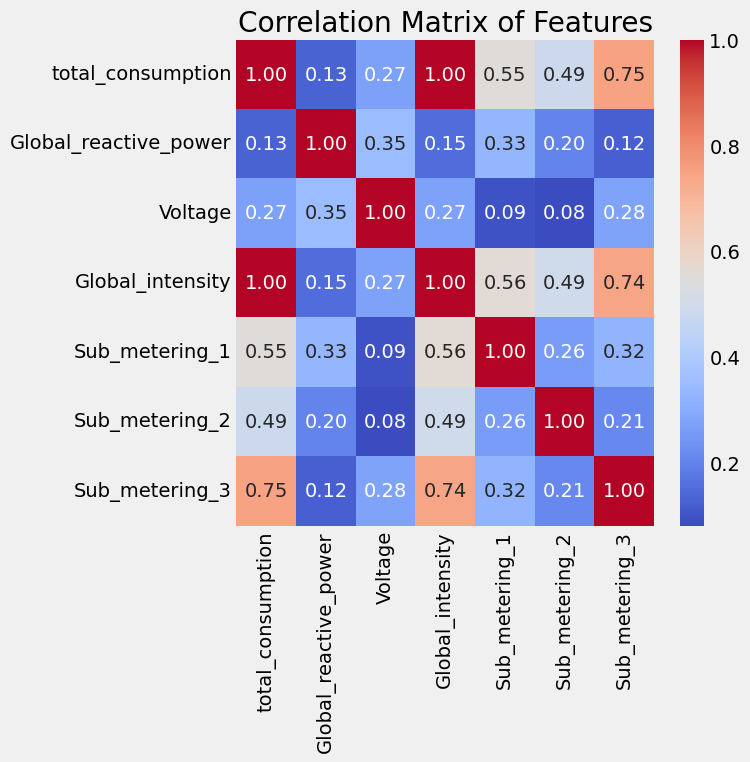

Most correlated features with 'total_consumption':
Global_intensity    0.999222
Sub_metering_3      0.751204
Sub_metering_1      0.549166
Name: total_consumption, dtype: float64


In [10]:
correlation_matrix = consumptions_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

# Define the threshold value
threshold = 0.5  
target_correlations = correlation_matrix['total_consumption'].drop('total_consumption', axis=0).abs()

# Filter features that have a correlation above the threshold
highly_correlated_features = target_correlations[target_correlations > threshold]
print("Most correlated features with 'total_consumption':")
print(highly_correlated_features.sort_values(ascending=False))

#### Observations and Insights About the Graph:

- **Primary Predictor**: 'Global_intensity' shows a very high correlation with 'total_consumption' (r = 0.999), indicating it's a primary factor in predicting consumption.
- **Secondary Factors**: 'Sub_metering_3' has a significant correlation (r = 0.75), while 'Sub_metering_1' shows a moderate relationship (r = 0.55) with total consumption.
- **Lesser Predictors**: Other features like 'Global_reactive_power', 'Voltage', and 'Sub_metering_2' are less correlated, suggesting a weaker influence on total consumption.

## EDA - Conclusion

- **Time Frame**: Data spans from **2006-12-16** to **2010-11-26**.
- **Record Count**: Dataset contains **1442 entries**.
- **Data Integrity**: No missing values detected.
- **Target Variable**: 
  - **Total consumption** is the variable of interest.
- **Predictive Features**: 
  - **Global_reactive_power** (weaker correlation)
  - **Voltage** (weaker correlation)               
  - **Global_intensity** (very high correlation, r = 0.999)
  - **Sub_metering_1** (moderate correlation)        
  - **Sub_metering_2** (weaker correlation)        
  - **Sub_metering_3** (high correlation, r = 0.75) 
  - **Date** is used as the DataFrame index and could inform seasonal trend analysis.
 
- **Feature Engineering**:
    - Potential for creating new features based on the **Date** to capture seasonality, as indicated by the graph's Trends Over Time Analysis.

## <a><span style="color:red">`Important Note` on Feature Engineering</span></a>
The dataset is from Sceaux, near Paris based on the [link](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption). To improve our analysis, we'll use weather data from the **Weather API**. This helps because weather affects energy use. We'll also consider **French holidays**, which could impact energy consumption.

### Read the French Holidays CSV File
I acquired this dataset from the website [Data.gouv.fr](https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/).

In [11]:
french_holidays_df = pd.read_csv("../data/raw/holidays/jours_feries_metropole.csv",
                         parse_dates=['date'])
french_holidays_df.head(3)

,date,annee,zone,nom_jour_ferie
0,2004-01-01,2004,Métropole,1er janvier
1,2004-04-12,2004,Métropole,Lundi de Pâques
2,2004-05-01,2004,Métropole,1er mai


In [12]:
start_date = french_holidays_df.date.min()
end_date = french_holidays_df.date.max()

print(f'Data spans from {str(start_date)[:10]} to {str(end_date)[:10]}')

Data spans from 2004-01-01 to 2029-12-25


We will use this data later to create a new column `is_holiday`, but for now let's focus on **processing the Weather Data**.

### Read the CSV Weather Files
I acquired this data from [Visual Crossing](https://www.visualcrossing.com/).

In [13]:
# Empty dictionary to store weather data
weather_dictionary = {}

# Directory containing the data files
data_directory = "../data/raw/weather/"

for file_name in os.listdir(data_directory):
    if file_name.endswith(".csv"):
        weather_dictionary[file_name] = pd.read_csv(os.path.join(data_directory, file_name),
                                                     parse_dates=['datetime', 'sunrise', 'sunset'],
                                                     index_col='datetime')

# Display the file names in the weather dictionary
print(weather_dictionary.keys())

dict_keys(['Sceaux 2006-12-01 to 2009-07-31.csv', 'Sceaux 2009-08-01 to 2011-01-31.csv'])


### Concatenate and Prepare the Weather Data in a Pandas DataFrame
Since I used VisualCrossing to fetch the weather data for the Sceaux City during the energy consumption data collection, I will prepare and incorporate it into my original data.

In [14]:
# Concatenate all DataFrames in weather_dictionary along rows
weather_df = pd.concat([weather_df for df_name, weather_df in weather_dictionary.items()], axis=0)

weather_df.tail(2)

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-30,Sceaux,1.5,-3.5,-1.4,-2.1,-8.5,-5.6,-4.5,80.3,0.0,0,0.0,NaN,0.0,0.0,30.8,15.2,18.0,1018.9,42.6,5.0,82.4,7.1,4.0,NaN,2011-01-30 08:24:01,2011-01-30 17:44:45,0.87,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"07149099999,07156099999,07146099999,0714509999..."
2011-01-31,Sceaux,-1.1,-4.2,-3.0,-3.2,-8.9,-6.7,-5.1,85.8,0.0,0,0.0,NaN,0.0,0.0,22.4,12.4,6.6,1024.9,70.7,3.0,79.2,6.8,3.0,NaN,2011-01-31 08:22:43,2011-01-31 17:46:23,0.91,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0714509999..."


### Missing Values per Column for the Weather Dataset
We will first analyze this data in depth, select the possible features that could make the ML model better. 

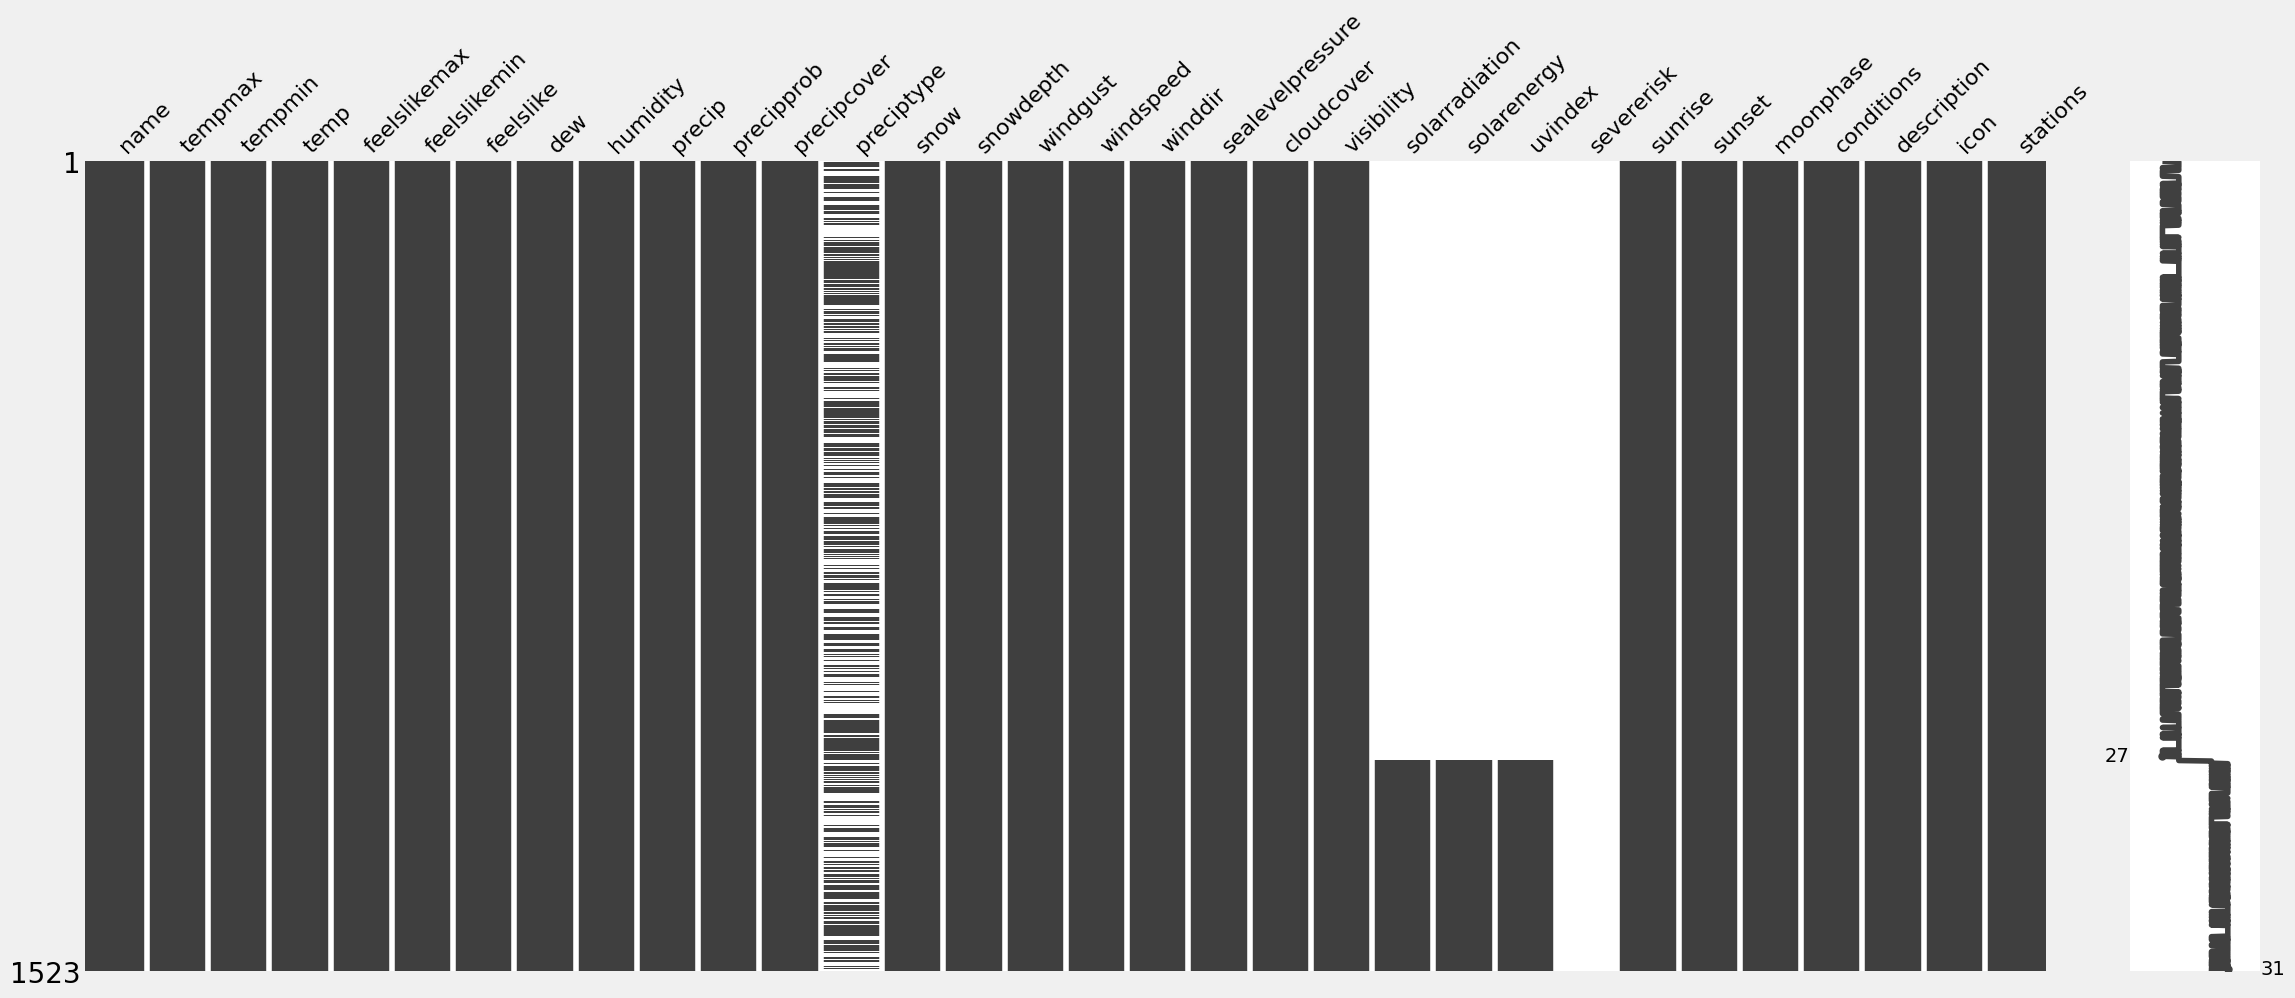

<Figure size 500x300 with 0 Axes>

In [15]:
# Generate the missing value matrix
msno.matrix(weather_df)

# Set the figure size to be smaller
plt.figure(figsize=(5, 3))

# Display the plot
plt.show()

### Data Preprocessing Steps

1. **Remove Missing Values:** Eliminate columns with missing data.
2. **Date Range Filtering:** Keep records between `2006-12-16` and `2010-11-26` (energy consumption interval).
3. **Encode 'Conditions':** Clean and apply One-Hot Encoding to the 'conditions' column, then drop it (OneHot encoding because the column isn't ordinal).
4. **Calculate Day Length:** Use 'Sunrise' and 'Sunset' to create a 'Day Length' feature, and remove the original columns (Daylight can impact energy consumption).

In [16]:
def clean_string(s):
    """
    Cleans a string: replaces spaces with underscores, removes special characters, and converts to lowercase.
    """
    return re.sub(r'[^a-zA-Z0-9\s]', '', s.replace(' ', '_')).lower()

def calculate_day_length(df, sunrise_col='sunrise', sunset_col='sunset'):
    """
    Adds 'day_length' to df calculated from 'sunrise' and 'sunset', and drops these columns.
    """
    df[sunrise_col] = pd.to_datetime(df[sunrise_col], format='%H:%M:%S').dt.time
    df[sunset_col] = pd.to_datetime(df[sunset_col], format='%H:%M:%S').dt.time
    df['day_length'] = ((pd.to_datetime(df[sunset_col].astype(str)) - pd.to_datetime(df[sunrise_col].astype(str))).dt.total_seconds()) / 3600.0
    return df.drop([sunrise_col, sunset_col], axis=1)

def preprocess_weather_data(df, start_date, end_date, columns_to_keep, column_to_encode):
    """
    Preprocesses weather data: sorts by index, filters by date, selects columns, encodes a column, and calculates day length.
    """
    # Ensure the DataFrame is sorted by its index
    df.sort_index(inplace=True)
    
    # Select specified columns
    df_selected = df[columns_to_keep].copy()
    
    # Filter by date range
    df_filtered = df_selected[(df_selected.index >= start_date) & (df_selected.index <= end_date)].copy()
    
    # Clean and encode specified column
    df_filtered[column_to_encode] = df_filtered[column_to_encode].apply(clean_string)
    dummies = pd.get_dummies(df_filtered[column_to_encode], prefix=column_to_encode)
    df_encoded = pd.concat([df_filtered, dummies], axis=1).drop(column_to_encode, axis=1)
    
    # Calculate day length and drop original sunrise and sunset columns
    return calculate_day_length(df_encoded)

In [17]:
# Columns to keep
columns_to_keep = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 
                   'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 
                   'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 
                   'visibility', 'sunrise', 'sunset', 'moonphase', 'conditions']

# Start and End Weather Data Interval
start_date='2006-12-16'
end_date='2010-11-26'

# Columns to Encode using the One Hot Encoding 
column_to_encode='conditions'

# Proecess the Weather Dataframe
processed_weather_df = preprocess_weather_data(df=weather_df, 
                                               start_date=start_date, 
                                               end_date=end_date, 
                                               columns_to_keep=columns_to_keep, 
                                               column_to_encode=column_to_encode)

processed_weather_df.head(2)

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-12-16,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889
2006-12-17,7.2,0.6,3.4,5.9,-1.4,2.4,2.3,92.4,0.314,100,8.33,0.0,0.0,17.2,9.2,227.6,1028.5,59.8,7.2,0.90,False,False,False,False,False,True,False,False,False,False,False,8.270833


### Join the Dataframes by index

In [18]:
processed_weather_df.head(1)

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-12-16,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889


In [19]:
consumptions_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0


In [20]:
weather_and_consumption_df = pd.merge(consumptions_df, processed_weather_df, left_index=True, right_index=True)
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889


### Add the French Holidays

In [21]:
# Convert the list of dates to a set for faster lookup
french_holidays_set = set(french_holidays_df.date)

# Add a new column 'is_holiday' to the DataFrame
weather_and_consumption_df['is_holiday'] = weather_and_consumption_df.index.isin(french_holidays_set)
weather_and_consumption_df.head(2)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889,False
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,7.2,0.6,3.4,5.9,-1.4,2.4,2.3,92.4,0.314,100,8.33,0.0,0.0,17.2,9.2,227.6,1028.5,59.8,7.2,0.90,False,False,False,False,False,True,False,False,False,False,False,8.270833,False


Let's check if May 1st, 2007 is labeled as a holiday or not 🤞

In [22]:
weather_and_consumption_df[weather_and_consumption_df.index=='2007-05-01'].is_holiday

2007-05-01    True
Freq: D, Name: is_holiday, dtype: bool

### Analyzing the Linear Correlation between the Target and the Features ( After **Feature Engineering** )

In [23]:
# Generate the correlation matrix
correlation_matrix = weather_and_consumption_df.corr()

# Define the threshold for high correlation
threshold = 0.5

# Identify features highly correlated with 'total_consumption'
highly_correlated_features = correlation_matrix['total_consumption'].drop('total_consumption').abs()
highly_correlated_features = highly_correlated_features[highly_correlated_features > threshold].sort_values(ascending=False)

# Print the most correlated features
print("Most correlated features with 'total_consumption':")
for feature in highly_correlated_features.index:
    print(" " + feature)

Most correlated features with 'total_consumption':
 Global_intensity
 Sub_metering_3
 Sub_metering_1
 temp
 day_length
 tempmax
 feelslike
 feelslikemax
 feelslikemin
 tempmin


As we can see, new features with a high correlation score have been introduced, indicating their potential usefulness in improving the performance of our machine learning model during development.

## <a><span style="color:green">Save the `Data`</span></a>
Now that the data is prepared, I will save it for another notebook to train the machine learning model.

In [24]:
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889,False


In [25]:
weather_and_consumption_df.to_csv('../data/processed/weather_and_consumption.csv', index=True)

## Connect with me 🌐
<div align="center">
  <a href="https://www.linkedin.com/in/labrijisaad/">
    <img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn" style="margin-bottom: 5px;"/>
  </a>
  <a href="https://github.com/labrijisaad">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="GitHub" style="margin-bottom: 5px;"/>
  </a>
</div>